In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load Dataset**

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(
    root=r'/content/drive/MyDrive/366/caltech-101/101_ObjectCategories',
    transform=transform
)

**Split Dataset**

In [ ]:
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size,
val_size, test_size])

**Data Loaders**

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

**Using Pre-trained Models**

**VGG19 Model**

In [ ]:
import torch
from torchvision.models import vgg19
model = vgg19(pretrained=True)
model.classifier[6] = torch.nn.Linear(4096, 101) # Adjust the final layer

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**ResNet50 Model**

In [ ]:
from torchvision.models import resnet50
model = resnet50(pretrained=True)

model.fc = torch.nn.Linear(2048, 101) # Adjust the final layer for 101

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**EfficientNet (EfficientNet-B0)**

In [ ]:
from torchvision.models import efficientnet_b0
model = efficientnet_b0(pretrained=True)
model.classifier[1] = torch.nn.Linear(1280, 101) # Adjust the final layer

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Part 4: Training the Model**

Define Loss and Optimizer

In [ ]:
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Train the Model**

In [ ]:
import torch

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)

# Example: Move a tensor to the selected device
tensor = torch.randn(10).to(device)

print(f"Using device: {device}")

Using device: cpu


In [ ]:
for epoch in range(10):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels % 101
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

**Validate the Model**

In [40]:
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        # Move images and labels to the same device as the model
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        # Compute validation metrics

**Parameter Tuning with Grid Search**

In [41]:
!pip install scikit-learn

In [42]:
from sklearn.model_selection import ParameterGrid

param_grid = {
	'lr': [0.1, 0.01, 0.001],
	'batch_size': [16, 32, 64]
}

best_params = None
best_accuracy = 0

for params in ParameterGrid(param_grid):
	optimizer = optim.Adam(model.parameters(), lr=params['lr'])
	train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)

	# Perform training and validation here
	# For demonstration, let's assume accuracy is calculated and assigned
	accuracy = 0.85  # Replace with actual accuracy calculation

	if accuracy > best_accuracy:
		best_accuracy = accuracy
		best_params = params

print(f"Best Params: {best_params}")

Best Params: {'batch_size': 16, 'lr': 0.1}


**Part 5: Evaluating the Model**

Evaluate on Test Data

In [43]:
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the same device as the model
        images = images.to(device)  # Move images to device
        labels = labels.to(device)  # Move labels to device
        outputs = model(images)
        # Compute test metrics

**Confusion Matrix**

In [44]:
from sklearn.metrics import confusion_matrix
y_pred = []
y_true = []
with torch.no_grad():
	for images, labels in test_loader:
		# Move images and labels to the same device as the model
		images = images.to(device)  # Move images to device
		labels = labels.to(device)  # Move labels to device # Added this line
		outputs = model(images)
		_, preds = torch.max(outputs, 1)
		y_pred.extend(preds.cpu().numpy()) # Moved preds to CPU before converting to numpy
		y_true.extend(labels.cpu().numpy()) # Moved labels to CPU before converting to numpy
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[29  0  0 ...  0  2  0]
 [ 0 45  0 ...  0  0  0]
 [ 0  1 51 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 6  0  0 ...  0  0  0]]


**Classification Report**

In [45]:
class_names = dataset.classes  # Define class_names based on the dataset

# Ensure the number of class names matches the number of unique labels in y_true
unique_labels = sorted(set(y_true))
adjusted_class_names = [class_names[i] for i in unique_labels]

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels=unique_labels, target_names=adjusted_class_names))

                   precision    recall  f1-score   support

BACKGROUND_Google       0.56      0.59      0.57        49
            Faces       0.98      0.98      0.98        46
       Faces_easy       1.00      0.96      0.98        53
         Leopards       0.94      0.94      0.94        18
       Motorbikes       0.99      0.98      0.98        81
        accordion       0.83      1.00      0.91         5
        airplanes       1.00      0.98      0.99        88
           anchor       1.00      1.00      1.00         2
              ant       0.67      1.00      0.80         6
           barrel       0.00      0.00      0.00         1
             bass       0.50      0.50      0.50         2
           beaver       0.38      0.50      0.43         6
        binocular       0.75      1.00      0.86         3
           bonsai       0.90      0.64      0.75        14
            brain       0.79      0.85      0.81        13
     brontosaurus       1.00      0.60      0.75       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Top-k Accuracy**

In [46]:
def top_k_accuracy(output, target, k=5):
	with torch.no_grad():
		max_k_preds = torch.topk(output, k, dim=1).indices
		correct = max_k_preds.eq(target.view(-1, 1).expand_as(max_k_preds))
		return correct.any(dim=1).float().mean().item()

**Per-Class Accuracy**

In [47]:
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_accuracy):
	print(f"Class {class_names[i]} Accuracy: {acc:.2f}")

Class BACKGROUND_Google Accuracy: 0.59
Class Faces Accuracy: 0.98
Class Faces_easy Accuracy: 0.96
Class Leopards Accuracy: 0.94
Class Motorbikes Accuracy: 0.98
Class accordion Accuracy: 1.00
Class airplanes Accuracy: 0.98
Class anchor Accuracy: 1.00
Class ant Accuracy: 1.00
Class barrel Accuracy: 0.00
Class bass Accuracy: 0.50
Class beaver Accuracy: 0.50
Class binocular Accuracy: 1.00
Class bonsai Accuracy: 0.64
Class brain Accuracy: 0.85
Class brontosaurus Accuracy: 0.60
Class buddha Accuracy: 0.60
Class butterfly Accuracy: 1.00
Class camera Accuracy: 1.00
Class cannon Accuracy: 0.56
Class car_side Accuracy: 0.92
Class ceiling_fan Accuracy: 0.67
Class cellphone Accuracy: 1.00
Class chair Accuracy: 0.71
Class chandelier Accuracy: 0.69
Class cougar_body Accuracy: 0.00
Class cougar_face Accuracy: 0.78
Class crab Accuracy: 0.60
Class crayfish Accuracy: 0.71
Class crocodile Accuracy: 0.43
Class crocodile_head Accuracy: 0.67
Class cup Accuracy: 0.40
Class dalmatian Accuracy: 1.00
Class doll

**t-SNE Visualization**

In [48]:
!pip install matplotlib

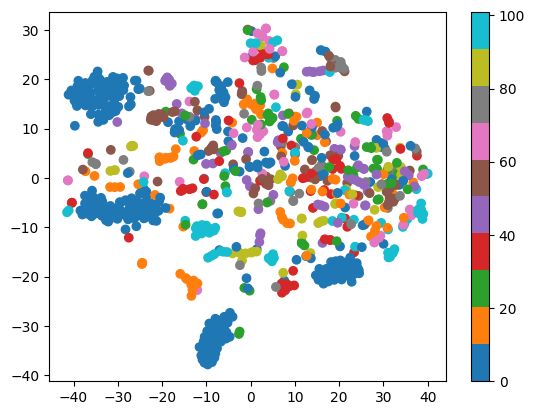

In [49]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

features = []
labels_list = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        # Move images to the same device as the model
        images = images.to(device)  # Move images to device

        output = model(images)
        features.append(output)
        labels_list.append(labels)

features = torch.cat(features).cpu().numpy() # Move features to CPU before converting to numpy
labels_list = torch.cat(labels_list).cpu().numpy() # Move labels_list to CPU before converting to numpy
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels_list, cmap='tab10')
plt.colorbar()
plt.show()

**Part 6: Explainable AI (XAI) with Grad-CAM**

**Install Grad-CAM Library**

In [50]:
!pip install grad-cam

**Apply Grad-CAM**

In [51]:
!pip uninstall pytorch-grad-cam -y
!pip install grad-cam

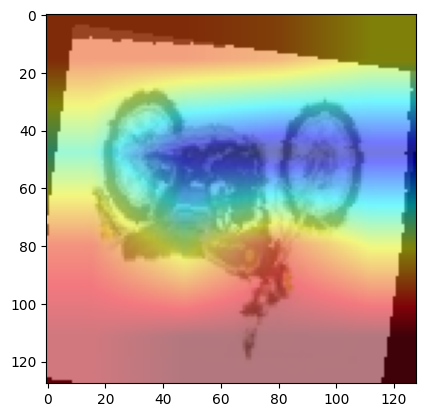

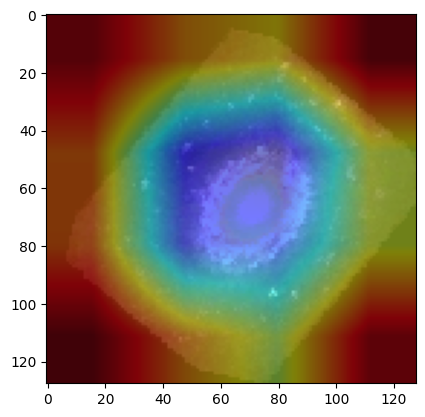

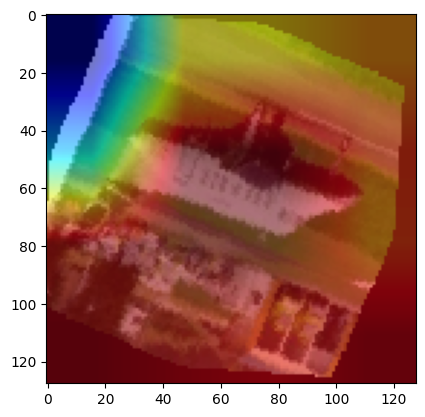

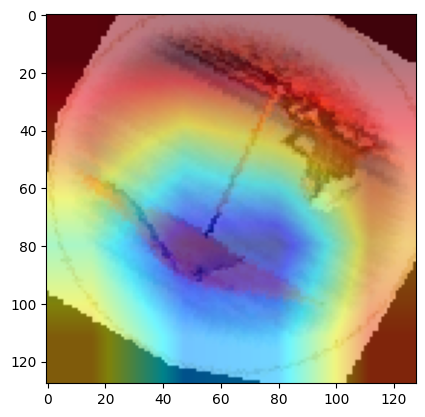

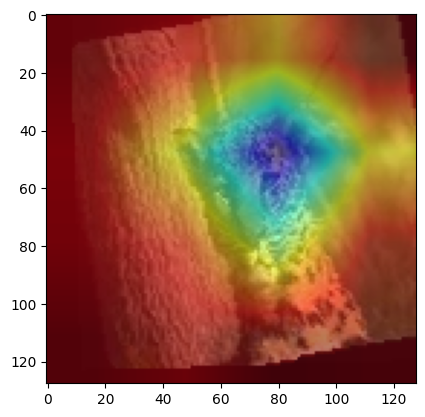

In [52]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt

# Adjust based on the model's architecture
# Check model architecture and set target layer
if isinstance(model, torch.nn.Sequential):  # VGG19
    target_layer = model.features[-1]
elif isinstance(model, torch.nn.Module) and hasattr(model, 'layer4'):  # ResNet50
    target_layer = model.layer4[-1]
elif isinstance(model, torch.nn.Module) and hasattr(model, 'features'):  # EfficientNet-B0
    target_layer = model.features[-1]
else:
    raise ValueError("Model architecture not recognized")

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Generate and display CAMs
count = 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    labels = labels % 101  # Ensure labels are within the correct range
    targets = [ClassifierOutputTarget(label.item()) for label in labels]
    grayscale_cam = cam(input_tensor=images, targets=targets)
    for i in range(len(images)):
        if count >= 5:
            break
        image = images[i].permute(1, 2, 0).cpu().numpy()
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
        cam_image = show_cam_on_image(image, grayscale_cam[i])
        plt.imshow(cam_image)
        plt.show()
        count += 1
    if count >= 5:
        break